# Загрузка Pandas и очистка данных

In [1]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re

from itertools import combinations
from scipy.stats import ttest_ind
from datetime import datetime
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

%matplotlib inline

In [2]:
df = pd.read_csv('main_task.csv')

In [3]:
# Ваш код по очистке данных и генерации новых признаков
# При необходимости добавьте ячейки

Restaurant_id — идентификационный номер ресторана / сети ресторанов;

City — город, в котором находится ресторан;

Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;

Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;

Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);

Price Range — диапазон цен в ресторане;

Number of Reviews — количество отзывов о ресторане;

Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;

URL_TA — URL страницы ресторана на TripAdvosor;

ID_TA — идентификатор ресторана в базе данных TripAdvisor.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


# Функции

In [5]:
#Заполнение значений наших новых столбцов
def find_item(cell):
    if item in cell:
        return 1
    return 0

In [6]:
# плотность распределения переменных
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='rating',
                data=df.loc[df.loc[:, column].isin(
                    df.loc[:, column].value_counts().index[:])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [7]:
# статистическая разница в распределении оценок по номинативным признакам, с помощью теста Стьюдента
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'],
                     df.loc[df.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [8]:
# распределение признака числовых переменных и количество пустых строк
def get_charts_col(column):
    df[column].hist()
    display(df[column].describe())
    print('Количество заполненных значений - ' + str(df[column].count()) +
          ' из 40000')

In [9]:
# формул интерквартильного расстояния для фильтра выбросов
def get_emission_filter(column, a=0, b=10):
    median = df[column].median()
    IQR = df[column].quantile(0.75) - df[column].quantile(0.25)
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75),
          "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    df[column].loc[df[column].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins=10, range=(a, b),
                                                                                              label='IQR')
    plt.legend()

In [10]:
#Названия столбцов приведем к нижнему регистру и заменим пробелы в названиях на нижнее подчеркивание
df.columns = df.columns.str.lower()
df.columns = [str(x).replace(' ', '_') for x in df.columns]
df.head(2)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032


Выведем уникальные значения в столбцах и значения, встретившиеся более 10 раз. 

In [11]:
for column in df.columns:
    print('-'*60)
    print('\t' , 'Отчет по колонке [', column, ']', '\t'*5)
    print('-'*60)
    print("Значений, встретившихся в столбце более 10 раз:",
          (df[column].value_counts() > 10).sum())
    print("Уникальных значений:", df[column].nunique())
    print('Все уникальные значения:', df[column].unique() , '\n')
            
    display(pd.DataFrame(df[column].value_counts()))
   

------------------------------------------------------------
	 Отчет по колонке [ restaurant_id ] 					
------------------------------------------------------------
Значений, встретившихся в столбце более 10 раз: 640
Уникальных значений: 11909
Все уникальные значения: ['id_5569' 'id_1535' 'id_352' ... 'id_7068' 'id_8887' 'id_6057'] 



,restaurant_id
id_871,18
id_227,18
id_633,18
id_436,18
id_430,17
...,...
id_3470,1
id_13014,1
id_13866,1
id_8407,1


------------------------------------------------------------
	 Отчет по колонке [ city ] 					
------------------------------------------------------------
Значений, встретившихся в столбце более 10 раз: 31
Уникальных значений: 31
Все уникальные значения: ['Paris' 'Stockholm' 'London' 'Berlin' 'Munich' 'Oporto' 'Milan'
 'Bratislava' 'Vienna' 'Rome' 'Barcelona' 'Madrid' 'Dublin' 'Brussels'
 'Zurich' 'Warsaw' 'Budapest' 'Copenhagen' 'Amsterdam' 'Lyon' 'Hamburg'
 'Lisbon' 'Prague' 'Oslo' 'Helsinki' 'Edinburgh' 'Geneva' 'Ljubljana'
 'Athens' 'Luxembourg' 'Krakow'] 



,city
London,5757
Paris,4897
Madrid,3108
Barcelona,2734
Berlin,2155
Milan,2133
Rome,2078
Prague,1443
Lisbon,1300
Vienna,1166


------------------------------------------------------------
	 Отчет по колонке [ cuisine_style ] 					
------------------------------------------------------------
Значений, встретившихся в столбце более 10 раз: 336
Уникальных значений: 9007
Все уникальные значения: ["['European', 'French', 'International']" nan
 "['Japanese', 'Sushi', 'Asian', 'Grill', 'Vegetarian Friendly', 'Vegan Options', 'Gluten Free Options']"
 ...
 "['Steakhouse', 'Barbecue', 'Australian', 'Argentinean', 'South American']"
 "['French', 'American', 'Cafe', 'Healthy', 'Soups']"
 "['French', 'Contemporary', 'Fusion', 'Gastropub']"] 



,cuisine_style
['Italian'],1032
['French'],805
['Spanish'],695
"['French', 'European']",405
['Cafe'],403
...,...
"['Cafe', 'European', 'Contemporary', 'Vegetarian Friendly']",1
"['European', 'Seafood', 'Mediterranean', 'Central European']",1
"['American', 'Irish', 'Cafe', 'British']",1
"['European', 'Italian', 'French']",1


------------------------------------------------------------
	 Отчет по колонке [ ranking ] 					
------------------------------------------------------------
Значений, встретившихся в столбце более 10 раз: 618
Уникальных значений: 11936
Все уникальные значения: [5570. 1537.  353. ... 8896. 6058. 6341.] 



,ranking
1080.0,19
437.0,18
491.0,18
345.0,18
431.0,18
...,...
14711.0,1
9409.0,1
14109.0,1
10501.0,1


------------------------------------------------------------
	 Отчет по колонке [ rating ] 					
------------------------------------------------------------
Значений, встретившихся в столбце более 10 раз: 9
Уникальных значений: 9
Все уникальные значения: [3.5 4.  4.5 5.  3.  2.5 2.  1.  1.5] 



,rating
4.0,13692
4.5,10929
3.5,6824
5.0,3879
3.0,2955
2.5,915
2.0,466
1.0,201
1.5,139


------------------------------------------------------------
	 Отчет по колонке [ price_range ] 					
------------------------------------------------------------
Значений, встретившихся в столбце более 10 раз: 3
Уникальных значений: 3
Все уникальные значения: ['$$ - $$$' nan '$$$$' '$'] 



,price_range
$$ - $$$,18412
$,6279
$$$$,1423


------------------------------------------------------------
	 Отчет по колонке [ number_of_reviews ] 					
------------------------------------------------------------
Значений, встретившихся в столбце более 10 раз: 368
Уникальных значений: 1459
Все уникальные значения: [ 194.   10.  688. ... 2297.  989. 1162.] 



,number_of_reviews
2.0,1916
3.0,1636
4.0,1370
5.0,1181
6.0,1018
...,...
2141.0,1
920.0,1
1404.0,1
979.0,1


------------------------------------------------------------
	 Отчет по колонке [ reviews ] 					
------------------------------------------------------------
Значений, встретившихся в столбце более 10 раз: 1
Уникальных значений: 33516
Все уникальные значения: ["[['Good food at your doorstep', 'A good hotel restaurant'], ['12/31/2017', '11/20/2017']]"
 "[['Unique cuisine', 'Delicious Nepalese food'], ['07/06/2017', '06/19/2016']]"
 "[['Catch up with friends', 'Not exceptional'], ['01/08/2018', '01/06/2018']]"
 ...
 "[['Good by swedish standards', 'A hidden jewel in the middle of Västertorp...'], ['11/03/2016', '04/12/2008']]"
 "[['Underground restaurant', 'Oldest Restaurant in Warsaw'], ['07/11/2017', '06/18/2017']]"
 "[['Average', 'Nice an informal'], ['01/31/2016', '07/04/2012']]"] 



,reviews
"[[], []]",6471
"[['Good Lebanese food', 'Decent place'], ['07/19/2017', '03/17/2017']]",2
"[['Sat night', 'Can\'t even explain.. ""A"" place.. A ""100...'], ['10/22/2017', '05/11/2017']]",2
"[['Healthy vegan doughnuts are posible', 'Best Vegan Donut in the world !!!'], ['11/17/2017', '11/16/2017']]",2
"[['Absolutely authentic and delicious!', 'Wonderful discovery'], ['09/30/2017', '08/04/2016']]",2
...,...
"[['surprisingly (for me) good.', 'Decent Vegan meal'], ['06/07/2017', '05/16/2017']]",1
"[['Good for a quick meal', 'Sushi for a Great Value'], ['12/27/2014', '09/26/2014']]",1
"[['Very good', 'Good Family Style Restaurant'], ['09/21/2017', '05/13/2017']]",1
"[['Mrs', 'Terrible staff'], ['05/27/2017', '05/20/2017']]",1


------------------------------------------------------------
	 Отчет по колонке [ url_ta ] 					
------------------------------------------------------------
Значений, встретившихся в столбце более 10 раз: 0
Уникальных значений: 39980
Все уникальные значения: ['/Restaurant_Review-g187147-d1912643-Reviews-R_Yves-Paris_Ile_de_France.html'
 '/Restaurant_Review-g189852-d7992032-Reviews-Buddha_Nepal-Stockholm.html'
 '/Restaurant_Review-g186338-d8632781-Reviews-ROKA_Mayfair-London_England.html'
 ...
 '/Restaurant_Review-g189852-d947615-Reviews-Sushi_Bar_Anu-Stockholm.html'
 '/Restaurant_Review-g274856-d1100838-Reviews-Honoratka_dawna_Oberza_na_Miodowej-Warsaw_Mazovia_Province_Central_Poland.html'
 '/Restaurant_Review-g187849-d1109020-Reviews-Taberna_Vasca-Milan_Lombardy.html'] 



,url_ta
/Restaurant_Review-g187514-d987900-Reviews-Compostela_Restaurante-Madrid.html,2
/Restaurant_Review-g187514-d11921719-Reviews-Crepets-Madrid.html,2
/Restaurant_Review-g187514-d11674463-Reviews-Beerhouse-Madrid.html,2
/Restaurant_Review-g187514-d3685055-Reviews-Shukran-Madrid.html,2
/Restaurant_Review-g187514-d697406-Reviews-Al_Mounia-Madrid.html,2
...,...
/Restaurant_Review-g274887-d8395091-Reviews-La_Vie_en_Rose-Budapest_Central_Hungary.html,1
/Restaurant_Review-g187331-d8499361-Reviews-Wok_Express-Hamburg.html,1
/Restaurant_Review-g187497-d12115145-Reviews-Greenshots-Barcelona_Catalonia.html,1
/Restaurant_Review-g187309-d2440838-Reviews-Zum_Sollner_Hirschen-Munich_Upper_Bavaria_Bavaria.html,1


------------------------------------------------------------
	 Отчет по колонке [ id_ta ] 					
------------------------------------------------------------
Значений, встретившихся в столбце более 10 раз: 0
Уникальных значений: 39980
Все уникальные значения: ['d1912643' 'd7992032' 'd8632781' ... 'd947615' 'd1100838' 'd1109020'] 



,id_ta
d8753348,2
d3685055,2
d11698990,2
d11999956,2
d3161682,2
...,...
d8490194,1
d11847277,1
d1380425,1
d7223185,1


In [12]:
#обнаружила, что ID_TA имеет задвоенности, просмотрим что у нас там.
id_ta2 = (df.id_ta.value_counts() > 1)[:20].index
df.loc[df.id_ta.isin(id_ta2)].sort_values(['id_ta'],ascending=False)
#в дублях у нас отличаются restaurant_id и ranking - остальные одинаковые поля, причем если посмотреть, 
#то можно обнаружить, что все задвоенности только в Мадриде
#не пришло в голову что с этим делать :)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta
8019,id_2361,Madrid,"['Seafood', 'Mediterranean', 'European', 'Span...",2363.0,4.0,$$ - $$$,190.0,"[['Nice restaurant in Madrid', 'Highly reccome...",/Restaurant_Review-g187514-d987900-Reviews-Com...,d987900
22998,id_2312,Madrid,"['Seafood', 'Mediterranean', 'European', 'Span...",2314.0,4.0,$$ - $$$,190.0,"[['Nice restaurant in Madrid', 'Highly reccome...",/Restaurant_Review-g187514-d987900-Reviews-Com...,d987900
15565,id_530,Madrid,"['Japanese', 'Vegetarian Friendly', 'Vegan Opt...",531.0,4.5,$$ - $$$,67.0,"[['Whenever in Madrid, we never miss this gem....",/Restaurant_Review-g187514-d9877640-Reviews-Ra...,d9877640
15295,id_475,Madrid,"['Japanese', 'Vegetarian Friendly', 'Vegan Opt...",476.0,4.5,$$ - $$$,67.0,"[['Whenever in Madrid, we never miss this gem....",/Restaurant_Review-g187514-d9877640-Reviews-Ra...,d9877640
10594,id_2677,Madrid,NaN,2679.0,5.0,NaN,10.0,"[['Absolutely authentic and delicious!', 'Wond...",/Restaurant_Review-g187514-d9802625-Reviews-La...,d9802625
12938,id_2486,Madrid,NaN,2488.0,5.0,NaN,10.0,"[['Absolutely authentic and delicious!', 'Wond...",/Restaurant_Review-g187514-d9802625-Reviews-La...,d9802625
13942,id_1103,Madrid,['Spanish'],1104.0,4.5,$$ - $$$,73.0,"[['ok for beer, not for dinner'], ['12/20/2017']]",/Restaurant_Review-g187514-d8753348-Reviews-Tr...,d8753348
31238,id_1212,Madrid,['Spanish'],1213.0,4.5,$$ - $$$,73.0,"[['ok for beer, not for dinner'], ['12/20/2017']]",/Restaurant_Review-g187514-d8753348-Reviews-Tr...,d8753348
36822,id_2487,Madrid,"['Italian', 'French', 'European']",2489.0,4.0,$$ - $$$,148.0,"[['Sat night', 'Can\'t even explain.. ""A"" plac...",/Restaurant_Review-g187514-d793170-Reviews-Car...,d793170
5240,id_2406,Madrid,"['Italian', 'French', 'European']",2408.0,4.0,$$ - $$$,148.0,"[['Sat night', 'Can\'t even explain.. ""A"" plac...",/Restaurant_Review-g187514-d793170-Reviews-Car...,d793170


25-й перцентиль: 10.0, 75-й перцентиль: 120.0, IQR: 110.0,  Границы выбросов: [-155.0, 285.0].


count    40000.000000
mean       123.669900
std        286.345718
min          2.000000
25%         10.000000
50%         38.000000
75%        120.000000
max       9660.000000
Name: number_of_reviews, dtype: float64

Количество заполненных значений - 40000 из 40000


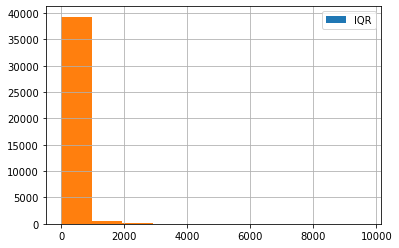

In [13]:
# Убираем Nan в столбцах по количеству отзывов и место, занимаемое рестораном - ставим среднее значение
# по городу
df['number_of_reviews'].fillna(0, inplace=True)
mean_number = round(df.groupby('city')['number_of_reviews'].mean(),0)
df['number_of_reviews'] = df.apply(lambda row: mean_number[row['city']] if row['number_of_reviews'] == 0 else row['number_of_reviews'], axis=1)
get_emission_filter('number_of_reviews')
get_charts_col('number_of_reviews')

25-й перцентиль: 3.0, 75-й перцентиль: 10.0, IQR: 7.0,  Границы выбросов: [-7.5, 20.5].


count    40000.000000
mean         6.439550
std          4.135223
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         18.000000
Name: count_restaurant, dtype: float64

Количество заполненных значений - 40000 из 40000


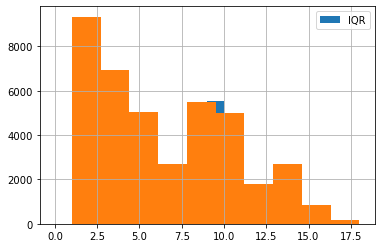

In [14]:
#Посмотрим, сколько у нас сетей рестаранов и создадим новый признак
net_restaurant = df.groupby(['restaurant_id']).restaurant_id.count().sort_values(ascending=False)
df['count_restaurant'] = df.apply(lambda row: net_restaurant[row['restaurant_id']], axis=1)
        # MAE: 0.09460565192527635
get_emission_filter('count_restaurant')
get_charts_col('count_restaurant')    

In [15]:
#cписок id ресторанов 
list_id = list(df.groupby(['restaurant_id']).restaurant_id.count().index)
len(list_id)

11909

25-й перцентиль: 1.0, 75-й перцентиль: 4.0, IQR: 3.0,  Границы выбросов: [-3.5, 8.5].


count    40000.000000
mean         2.390325
std          2.057627
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         21.000000
Name: cuisine_count, dtype: float64

Количество заполненных значений - 40000 из 40000


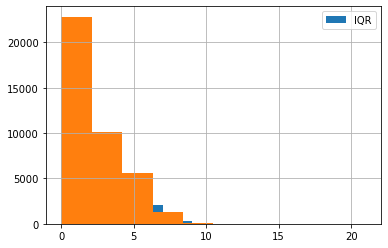

In [16]:
#Создадим столбец с количеством кухонь в ресторане
df['cuisine_count'] = df['cuisine_style'].str.count(',')+1
df['cuisine_count'].fillna(0, inplace=True)
# MAE: 0.099889439573008
get_emission_filter('cuisine_count')
get_charts_col('cuisine_count')    

ПО графику видим, что очень многоу ресторанов не заполненных типов кухонь

In [17]:
df.head(2)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta,count_restaurant,cuisine_count
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,3,3.0
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,10,0.0


# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [18]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(df.select_dtypes(include=['object']), axis = 1)
y = df['rating']
X = X.drop('rating', axis = 1)

# пробуем заменять пропуски на среднее арифмитическое по столбцу
X.ranking = X.ranking.fillna(X.ranking.mean())
X['number_of_reviews'] = X['number_of_reviews'].fillna(X['number_of_reviews'].mean())
y = y.fillna(y.mean())

# Создаём, обучаем и тестируем модель

In [19]:
def create_train_test(X,y):
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    regr = RandomForestRegressor(n_estimators=100) # Создаём модель
    regr.fit(X_train, y_train) # Обучаем модель на тестовом наборе данных

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
    y_pred = regr.predict(X_test)

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
    return 'MAE:', metrics.mean_absolute_error(y_test, y_pred)

In [20]:
create_train_test(X,y)

('MAE:', 0.4031829880952381)

# 4.1 Вопросы о ценах


In [21]:
# Сколько вариантов непустых значений встречается в столбце Price Range?
price = df['price_range'].unique()
print('В столбце "Price Range" непустых значений встречается ' + str(len(price)-1))

# Как в датафрейме обозначается самый низкий уровень цен и самый высокий уровень цен?
print('Самый низкий уровень цен обозначается символом: ' + price[3])
print('Самый высокий уровень цен обозначается символом: ' + price[2])

# Сколько ресторанов относятся к среднему ценовому сегменту?
count_mean = df['price_range'].loc[(df['price_range'] == '$$ - $$$')].count()
print('Количество ресторанов, относящихся к среднему ценовому сегменту равно '+ str(count_mean))

В столбце "Price Range" непустых значений встречается 3
Самый низкий уровень цен обозначается символом: $
Самый высокий уровень цен обозначается символом: $$$$
Количество ресторанов, относящихся к среднему ценовому сегменту равно 18412


25-й перцентиль: 1.0, 75-й перцентиль: 4.0, IQR: 3.0,  Границы выбросов: [-3.5, 8.5].


count    40000.000000
mean         2.390325
std          2.057627
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         21.000000
Name: cuisine_count, dtype: float64

Количество заполненных значений - 40000 из 40000


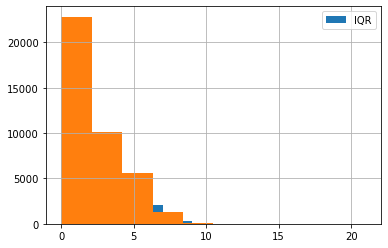

In [22]:
#Заменим значения Price Range на числа, 1 = $, 2 = $$ - $$$, 3 = $$$$
df.loc[df['price_range'] == '$','price_range'] = 1
df.loc[df['price_range'] == '$$ - $$$','price_range'] = 2
df.loc[df['price_range'] == '$$$$','price_range'] = 3
df['price_range'].fillna(2, inplace=True)
get_emission_filter('cuisine_count')
get_charts_col('cuisine_count')    

# 4.2 Вопрос о городах

In [23]:
# Сколько городов представлено в наборе данных?
citys = []
for city in df.city:  # начинаем перебор всех городов
   if not(city in citys):  # если город ещё не встречался
        citys.append(city) # добавляем его к списку citys
        
len(citys)

31

In [24]:
#Попробуем внести внешние данные, добавим страны и посмотрим, что нам даст.
country = {'Paris': 'France', 'Stockholm': 'Sweden', 'London': 'Great_Britain', 'Berlin': 'Germany', 'Munich': 'Germany',
           'Oporto': 'Portugal', 'Milan': 'Italy', 'Bratislava': 'Slovakia', 'Vienna': 'Austria', 'Rome': 'Italy', 
           'Barcelona': 'Spain', 'Madrid': 'Spain', 'Dublin': 'Ireland', 'Brussels': 'Belgium', 'Zurich': 'Switzerland',
           'Warsaw': 'Poland', 'Budapest': 'Hungary', 'Copenhagen': 'Denmark', 'Amsterdam': 'Netherlands',
           'Lyon': 'France', 'Hamburg': 'Germany', 'Lisbon': 'Portugal', 'Prague': 'Czech', 'Oslo': 'Norway',
           'Helsinki': 'Finland', 'Edinburgh': 'Scotland', 'Geneva': 'Switzerland', 'Ljubljana': 'Slovenia',
           'Athens': 'Greece', 'Luxembourg': 'Luxembourg', 'Krakow': 'Poland'}
df['country'] = df.apply(lambda row: country[row['city']], axis=1)
df = pd.get_dummies(df, columns=[ 'country',], dummy_na=True)

25-й перцентиль: 975.0, 75-й перцентиль: 5575.0, IQR: 4600.0,  Границы выбросов: [-5925.0, 12475.0].


count    40000.000000
mean      3292.886225
std       2952.803655
min        174.000000
25%        975.000000
50%       2148.000000
75%       5575.000000
max       8982.000000
Name: сity_population, dtype: float64

Количество заполненных значений - 40000 из 40000


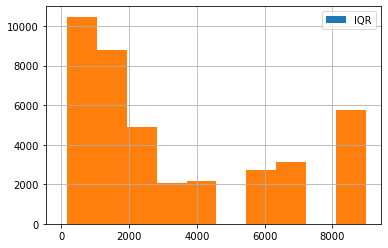

In [25]:
сity_population = dict_Сity_population= {'Paris': 2148, 'Stockholm': 975, 'London': 8982, 'Berlin': 3769, 'Munich': 1472,
           'Oporto': 214, 'Milan': 1352, 'Bratislava': 424, 'Vienna': 1897, 'Rome': 2873, 
           'Barcelona': 5575, 'Madrid': 6642, 'Dublin': 1388, 'Brussels': 174, 'Zurich': 402,
           'Warsaw': 1708, 'Budapest': 1752, 'Copenhagen': 602, 'Amsterdam': 821,
           'Lyon': 513, 'Hamburg': 1899, 'Lisbon': 504, 'Prague': 1309, 'Oslo': 681,
           'Helsinki': 631, 'Edinburgh': 482, 'Geneva': 499, 'Ljubljana': 279,
           'Athens': 664, 'Luxembourg': 613, 'Krakow': 769                                        }
df['сity_population'] = df.apply(lambda row: сity_population[row['city']], axis = 1)
get_emission_filter('сity_population')
get_charts_col('сity_population')    

In [26]:
%%time
#создадим колонки с городами и проставим 1, там где находится ресторан, остальноые 0.
for item in citys: # Wall time: 1.1 s
    df[item] = df['city'].apply(find_item)   
    df[item].fillna(0, inplace=True) 
# df = pd.get_dummies(df, columns=[ 'city',], dummy_na=True)

Wall time: 1.14 s


# 4.3 Вопросы о кухнях

In [27]:
# Сколько типов кухонь представлено в наборе данных?
сuisines = []
filtr_сuisine = df['cuisine_style'].dropna(how='any')
for сuisine in filtr_сuisine:
    сuisine = сuisine[1:-1].replace(", ", ",")
    сuisine = сuisine.split(',')
    for cuis in сuisine:
        if not(cuis in сuisines):  # если город ещё не встречался
            сuisines.append(cuis) # добавляем его к списку citys
            
len(сuisines)

125

In [28]:
# Какая кухня представлена в наибольшем количестве ресторанов? 
# Введите название кухни без кавычек или апострофов.
search_сuisine = pd.Series()
for сuisine in сuisines:
    search_сuisine[сuisine] = df['cuisine_style'].str.contains(сuisine, na=False).value_counts()[True]

search_сuisine = pd.Series(search_сuisine)
search_сuisine.sort_values(ascending=False).index[0]

"'Vegetarian Friendly'"

In [29]:
search_сuisine.sort_values(ascending=False)

'Vegetarian Friendly'    11189
'European'               10060
'Mediterranean'           6277
'Italian'                 5964
'Vegan Options'           4486
                         ...  
'Salvadoran'                 1
'Yunnan'                     1
'Xinjiang'                   1
'Burmese'                    1
'Latvian'                    1
Length: 125, dtype: int64

In [30]:
%%time
#создадим колонки с каждом видом кухни и проставим 1, 
#for item in сuisines:
#    df[item] = df['cuisine_style'].dropna(how='any').apply(find_item)   
#    df[item].fillna(0, inplace=True) 
# Wall time: 10.8 s
df['cuisine_style'].fillna(0, inplace=True) 
df['cuisine_style'] = df['cuisine_style'].apply(lambda x: re.findall(r"[^'][\w\s]+[^']", str(x)))
df = pd.concat([df, pd.get_dummies(df.explode('cuisine_style')['cuisine_style'], dummy_na=True)], axis = 1)    
# Wall time: 1.32 s

Wall time: 1.34 s


In [31]:
# Какое среднее количество кухонь предлагается в одном ресторане? Если в данных отсутствует информация
# о типах кухонь, то считайте, что в этом ресторане предлагается только один тип кухни. Ответ 
# округлите до одного знака после запятой.
restoran_сuisine = df['cuisine_style'].str.count(',')+1
restoran_сuisine = restoran_сuisine.fillna(1)
round(restoran_сuisine.mean(),1)

1.0

# 4.4 Вопросы об отзывах

In [32]:
# Когда был оставлен самый свежий отзыв? Введите ответ в формате yyyy-mm-dd.
reviews = pd.DataFrame([re.findall(r'\d{2}/\d{2}/\d{4}', x) for x in df.reviews]) #отбираю только даты
reviews.columns = ['data1', 'data2']
reviews.fillna('01/01/2000', inplace=True)
reviews['data1'] = pd.to_datetime(reviews['data1'])
reviews['data2'] = pd.to_datetime(reviews['data2'])
print(reviews.data1.max().strftime('%Y-%m-%d'))
print(reviews.data2.max().strftime('%Y-%m-%d'))

2018-02-26
2018-02-26


In [35]:
reviews.data2.isna().value_counts()

False    104916
Name: data2, dtype: int64

In [36]:
reviews.data1.isnull().sum()

0

In [ ]:
#Какое максимальное количество дней отделяет даты публикации отзывов, размещённых на 
#сайте ресторана? Введите количество дней в виде целого числа.
df['data0'] = df.data1 - df.data2
print(df.data0.max())

25-й перцентиль: 9.0, 75-й перцентиль: 142.0, IQR: 133.0,  Границы выбросов: [-190.5, 341.5].


count    104916.000000
mean        489.385871
std        1499.218145
min           0.000000
25%           9.000000
50%          43.000000
75%         142.000000
max        6626.000000
Name: delta, dtype: float64

Количество заполненных значений - 104916 из 40000


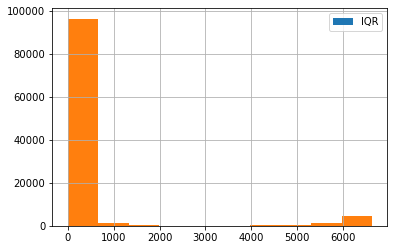

In [37]:
# создадим столбец с разницей последнего отзыва и текущей датой
df['delta'] = abs((reviews.data1 - reviews.data2).dt.days)
get_emission_filter('delta')
get_charts_col('delta')

25-й перцентиль: 1015.0, 75-й перцентиль: 1238.0, IQR: 223.0,  Границы выбросов: [680.5, 1572.5].


count    104916.000000
mean       1707.471501
std        1820.217513
min         948.000000
25%        1015.000000
50%        1075.000000
75%        1238.000000
max        7579.000000
Name: delta_today, dtype: float64

Количество заполненных значений - 104916 из 40000


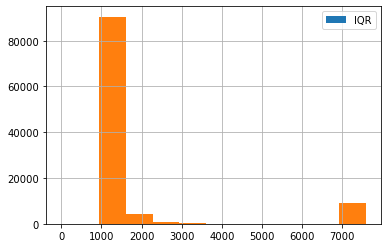

In [38]:
today = pd.to_datetime(datetime.now())
reviews['delta_today'] = reviews.apply(lambda row: (today - row.data1).days if row.data1 > row.data2 else (today - row.data2).days, axis=1)
df['delta_today'] = reviews['delta_today']
get_emission_filter('delta_today')
get_charts_col('delta_today')

In [39]:
df.head(2)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta,count_restaurant,cuisine_count,country_Austria,country_Belgium,country_Czech,country_Denmark,country_Finland,country_France,country_Germany,country_Great_Britain,country_Greece,country_Hungary,country_Ireland,country_Italy,country_Luxembourg,...,Spanish,Sri Lankan,Steakhouse,Street Food,Sushi,Swedish,Swiss,Taiwanese,Thai,Tibetan,Tunisian,Turkish,Ukrainian,Uzbek,Vegan Options,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan,NaN,delta,delta_today
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,2,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,3,3.0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,1005
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,2,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,3,3.0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,1005


In [40]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(df.select_dtypes(include=['object']), axis = 1)
y = df['rating']
X = X.drop(['rating'], axis = 1)

In [43]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104916 entries, 0 to 39999
Columns: 190 entries, ranking to delta_today
dtypes: float64(3), int64(36), uint8(151)
memory usage: 47.1 MB


In [42]:
create_train_test(X,y)

('MAE:', 0.09113195318159285)